# Invert three surveys line for a thin plate using the surrogate model

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_three_lines_transmitters.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

> This notebook assumes that you have created a surrogate model by executing the following two notebooks:
> - [Latin Hypercube Sampling](./three_survey_lines_latin_hypercube_sampling.ipynb) 
> - [Surrogate model creation](./three_survey_lines_surrogate_model_creation.ipynb)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git
# !pip install smt
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/vtem_max

In [2]:
# If this notebook is run locally PyP223 and smt need to be installed separately by uncommenting the following lines, 
# that is by removing the # and the white space between it and the exclamation mark.
# !pip install git+https://github.com/JuergHauser/PyP223.git
# !pip install smt

In [3]:
import arviz
import bayesbay
from vtem_max_forward_lib import (
    problem_setup, 
    system_spec, 
    survey_setup, 
    ForwardWrapper, 
    plot_predicted_profile, 
    plot_transient, 
    plot_plate_faces, 
    plot_plate_faces_single
)
import functools
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
import numpy as np

import cofi

np.random.seed(42)

## Background

This example inverts three survey line of VTEM max data using the vertical component for a thin plate target. It thus becomes possible to invert for the easting,northing, depth of the plate reference point, the plate dip and plate azimuth. Solving the forward problem, that is  calculating the objective function, usess the surrogate model that has been created by the [Kriging approach](./three_survey_lines_surrogate_model_creation.ipynb) applied to the [latin hypercube samples](three_survey_lines_latin_hypercube_sampling.ipynb) of the objective function.

## Problem definition

In [4]:
tx_min = 115
tx_max = 281
tx_interval = 15
ty_min = 25
ty_max = 176
ty_interval = 75
tx_points = np.arange(tx_min, tx_max, tx_interval)
ty_points = np.arange(ty_min, ty_max, ty_interval)
n_transmitters = len(tx_points) * len(ty_points)
tx, ty = np.meshgrid(tx_points, ty_points)
tx = tx.flatten()
ty = ty.flatten()

In [5]:
fiducial_id = np.arange(len(tx))
line_id = np.zeros(len(tx), dtype=int)
line_id[ty == ty_points[0]] = 0
line_id[ty == ty_points[1]] = 1
line_id[ty == ty_points[2]] = 2

In [6]:
survey_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": np.array([50] * n_transmitters),                     # transmitter height/z-position
    "tazi": np.deg2rad(np.array([90] * n_transmitters)),    # transmitter azimuth
    "tincl": np.deg2rad(np.array([6] * n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": np.array([100] * n_transmitters),                    # receiver northing/y-position
    "rz": np.array([50] * n_transmitters),                     # receiver height/z-position
    "trdx": np.array([0] * n_transmitters),                    # transmitter receiver separation inline
    "trdy": np.array([0] * n_transmitters),                    # transmitter receiver separation crossline
    "trdz": np.array([0] * n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "line_id": line_id                  # id for each line
}

In [7]:
true_model = {
    "res": np.array([300, 1000]), 
    "thk": np.array([20]), 
    "peast": np.array([175]), 
    "pnorth": np.array([100]), 
    "ptop": np.array([30]), 
    "pres": np.array([0.1]), 
    "plngth1": np.array([100]), 
    "plngth2": np.array([100]), 
    "pwdth1": np.array([0.1]), 
    "pwdth2": np.array([90]), 
    "pdzm": np.array([75]),
    "pdip": np.array([60])
}

In [8]:
forward = ForwardWrapper(true_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "peast", "ptop", "pwdth2"], data_returned=["vertical"])

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']


In [9]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'pdzm', 'peast', 'ptop', 'pwdth2']

In [10]:
true_param_value = np.array([60.,65., 175., 30., 90.])

##  Ensemble method using the surrogate model

In [11]:
filename = "kriging_surrogate_model.pkl"
with open(filename, "rb") as f:
   sm = pickle.load(f)

**Initialise a model for inversion**

In [12]:
init_param_value = np.array([45, 90, 160, 35, 80])
m_min = np.array([15, 35, 155, 30, 65])
m_max = np.array([75, 145, 185, 40, 115])

**Define uniform priors for each model parameter**

In [13]:
def initialize_param(param, position=None, value=1):
    return np.array([value]) + 0.5 * np.random.randn()

parameters = []
for iparam, (vmin, vmax) in enumerate(zip(m_min, m_max)):
    parameter = bayesbay.prior.UniformPrior(
        name=f"m{iparam}",
        vmin=m_min[iparam],
        vmax=m_max[iparam],
        perturb_std=(vmax - vmin) / 20,
    )
    custom_init = functools.partial(initialize_param, value=init_param_value[iparam])
    parameter.set_custom_initialize(custom_init)
    parameters.append(parameter)

param_space = bayesbay.parameterization.ParameterSpace(
    name="param_space",
    n_dimensions=1,
    parameters=parameters,
)
parameterization = bayesbay.parameterization.Parameterization(param_space)

**Define the log likelihood**

In [15]:
def my_objective(model):
    val = sm.predict_values(model)[0][0]
    if val < 1e-3:
        return 1e-3
    else:
        return val
        
def my_log_likelihood(state, *args, **kwargs):
    model = np.array(
        [state["param_space"][f"m{i}"] for i in range(init_param_value.size)]
    )
    return -0.5 * my_objective(model.T)

log_likelihood = bayesbay.likelihood.LogLikelihood(log_like_func=my_log_likelihood)

**Initialize the Markov chains**

In [16]:
n_chains = 12
walkers_start = []
for i in range(n_chains):
    walkers_start.append(
        parameterization.initialize()
    )  # A bayesbay.State is appended to walkers_start for each chain


**Define CoFI options**

In [18]:
inv_options = cofi.InversionOptions()
inv_options.set_tool("bayesbay")
inv_options.set_params(
    walkers_starting_states=walkers_start,
    perturbation_funcs=parameterization.perturbation_funcs,
    log_like_ratio_func=log_likelihood,
    n_chains=n_chains,
    n_iterations=5_000,
    burnin_iterations=500,
    verbose=False,
    save_every=25,
)

**Define CoFI inverse problem and run**

In [19]:
inv = cofi.Inversion(cofi.BaseProblem(), inv_options)
inv_result = inv.run()

## Plotting

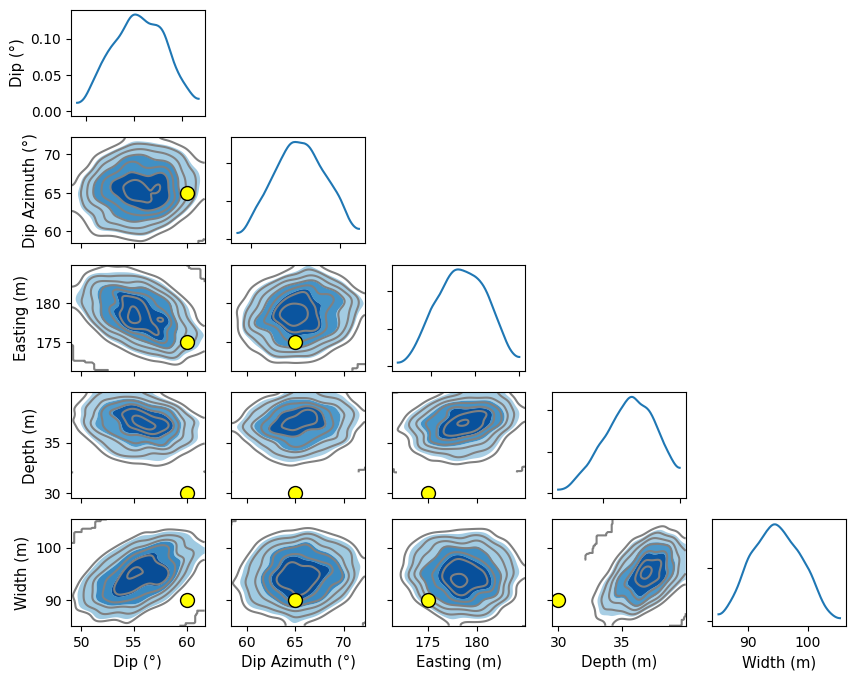

In [20]:
arviz.style.use("default")
var_names = [
    "Dip (\u00b0)",
    "Dip Azimuth (\u00b0)",
    "Easting (m)",
    "Depth (m)",
    "Width (m)",
]

results = inv_result.models
posterior_samples = {
    f"{var_names[i]}": np.concatenate(results[f"param_space.m{i}"])
    for i in range(init_param_value.size)
}

true_values = {
    f"{var_names[i]}": true_param_value[i] for i in range(init_param_value.size)
}


fig, axes = plt.subplots(5, 5, figsize=(10, 8))
_ = arviz.plot_pair(
    posterior_samples,
    marginals=True,
    kind="kde",
    kde_kwargs={
        "hdi_probs": [0.3, 0.6, 0.9],  # Plot 30%, 60% and 90% HDI contours
        "contourf_kwargs": {"cmap": "Blues"},
    },
    ax=axes,
    textsize=10,
)

for i, j in np.ndindex(axes.shape):
    if i == j:
        continue
    xlabel = axes[-1, j].get_xlabel()
    ylabel = axes[i, 0].get_ylabel()
    x_true = true_values[xlabel]
    y_true = true_values[ylabel]
    axes[i, j].plot(x_true, y_true, "yellow", marker="o", ms=10, markeredgecolor="k")

plt.show()

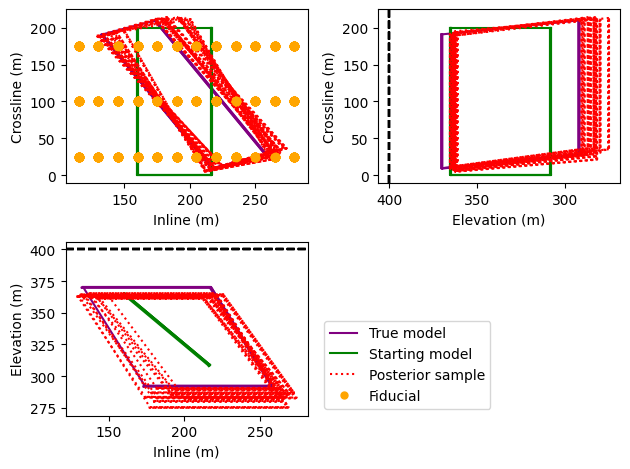

In [21]:
_, axes = plt.subplots(2, 2)
axes[1, 1].axis("off")
plot_plate_faces(
    "plate_true",
    forward,
    true_param_value,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="purple",
    label="True model",
)
plot_plate_faces(
    "plate_init",
    forward,
    init_param_value,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="green",
    label="Starting model",
)


plt.tight_layout()


idraw = np.random.randint(0, len(posterior_samples[var_names[0]]))

sample = np.array([posterior_samples[name][idraw] for name in var_names])

plot_plate_faces(
    "plate_inverted",
    forward,
    sample,
    axes[0, 0],
    axes[0, 1],
    axes[1, 0],
    color="red",
    label="Posterior sample",
    linestyle="dotted",
)

point = Line2D(
    [0],
    [0],
    label="Fiducial",
    marker="o",
    markersize=5,
    markeredgecolor="orange",
    markerfacecolor="orange",
    linestyle="",
)

handles, labels = axes[1, 0].get_legend_handles_labels()
handles.extend([point])

axes[1, 0].legend(handles=handles, bbox_to_anchor=(1.04, 0), loc="lower left")


# plot 10 randomly selected samples of the posterior distribution

idraws = np.random.choice(
    np.arange(0, len(posterior_samples[var_names[0]])), 10, replace=False
)
for idraw in idraws:
    sample = np.array([posterior_samples[name][idraw] for name in var_names])
    plot_plate_faces(
        "plate_inverted",
        forward,
        sample,
        axes[0, 0],
        axes[0, 1],
        axes[1, 0],
        color="red",
        label="Posterior sample",
        linestyle="dotted",
    )

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [23]:
watermark_list = ["bayesbay", "cofi", "numpy", "scipy", "matplotlib","smt"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

bayesbay 0.3.1
cofi 0.2.9
numpy 2.1.3
scipy 1.14.1
matplotlib 3.9.2
smt 2.8.0
